In [16]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore") 

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [17]:
# Reading AAPL dataset
ticker = "AAPL"

df = pd.read_csv(f'data/stocks/{ticker}.csv', parse_dates=['Date'])
df["Difference"] = df["Close"].diff()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Difference
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400,NaN
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200,-0.026786
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000,-0.035714
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400,0.011161
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400,0.013393


In [18]:
# Defining a function that will contain stocks data for a specific company
def specific_data(company, df, start = dt.datetime(1990,1,1), end = dt.datetime(2024,1,1)):
    # df["Name"] = company
    date_filtered_data = df[(df['Date'] > start) & (df['Date'] < end)]
    return date_filtered_data

df = specific_data(ticker, df)

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Difference
2287,1990-01-02,1.258929,1.339286,1.250000,1.330357,1.078869,45799600,0.071429
2288,1990-01-03,1.357143,1.357143,1.339286,1.339286,1.086111,51998800,0.008929
2289,1990-01-04,1.366071,1.383929,1.330357,1.343750,1.089730,55378400,0.004464
2290,1990-01-05,1.348214,1.366071,1.321429,1.348214,1.093350,30828000,0.004464
2291,1990-01-08,1.339286,1.357143,1.321429,1.357143,1.100591,25393200,0.008929


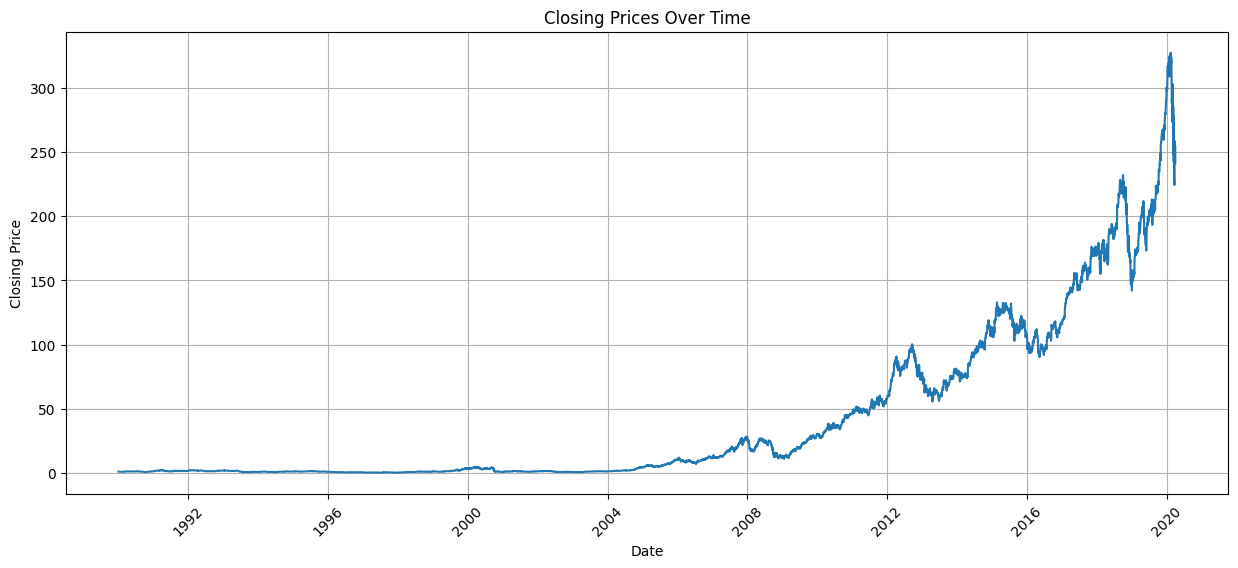

In [19]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Close'])
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

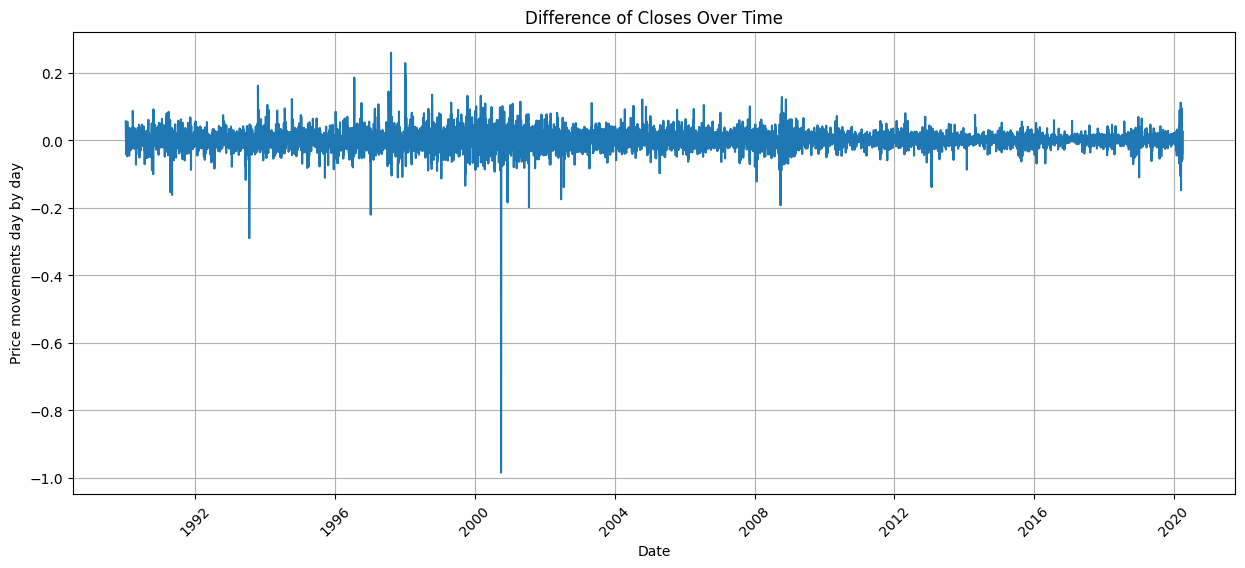

In [20]:
# Convert 'Date' column to datetime

plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df["Difference"] / df["Open"])
plt.title('Difference of Closes Over Time')
plt.xlabel('Date')
plt.ylabel('Price movements day by day')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

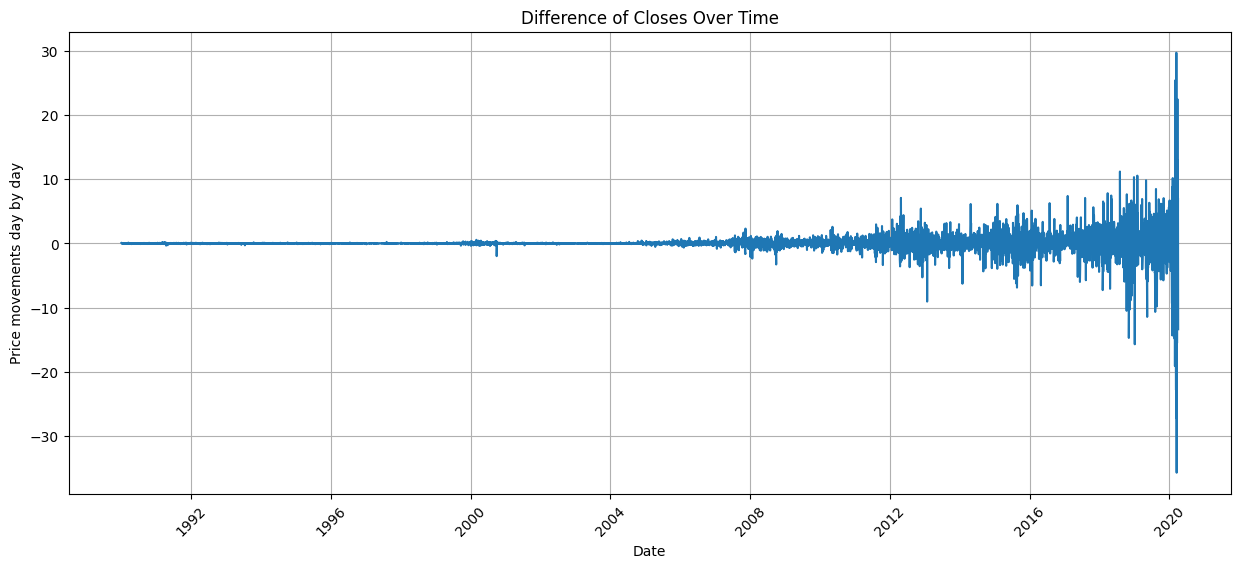

In [21]:
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Difference'])
plt.title('Difference of Closes Over Time')
plt.xlabel('Date')
plt.ylabel('Price movements day by day')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [22]:
scaler = MinMaxScaler()
close_scaler = MinMaxScaler()
without_date = df.drop( "Date", axis="columns")

df_train, df_test = train_test_split(without_date, test_size=0.2, shuffle=False)

close_scaler.fit(np.array(df_train["Close"]).reshape(-1,1))
print(f"{close_scaler.scale_}, {close_scaler.min_}, ")
scaled_train = scaler.fit_transform(df_train)
scaled_test = scaler.transform(df_test)

print(scaled_train.shape)
print(scaled_test.shape)

[0.01001623], [-0.00462804], 
(6097, 7)
(1525, 7)


In [23]:
past = 7

# Prepare sequences for LSTM
X_train, y_train = [], []
for i in range(past, len(scaled_train)):
    X_train.append(scaled_train[i - past:i])
    y_train.append(scaled_train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(past, len(scaled_test)):
    X_test.append(scaled_test[i - past:i])
    y_test.append(scaled_test[i])
X_test, y_test = np.array(X_test), np.array(y_test)

print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(6090, 7, 7)
(6090, 7)
Testing set size:-
(1518, 7, 7)
(1518, 7)


(None, None)

In [24]:
# Initialize a sequential model
model = Sequential()

# First LSTM layer with 50 units, input shape, and return sequences
model.add(LSTM(units=64, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

# Second LSTM layer with 50 units and return sequences
model.add(LSTM(units=64, activation="relu", return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer with 50 units
model.add(LSTM(units=64))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(1))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 64)             18432     
                                                                 
 dropout_3 (Dropout)         (None, 7, 64)             0         
                                                                 
 lstm_4 (LSTM)               (None, 7, 64)             33024     
                                                                 
 dropout_4 (Dropout)         (None, 7, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [25]:
model.compile(loss='mse',optimizer='adam')

In [26]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'my_weights.h5', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our lstm model
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=24,
          batch_size=8,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/24
762/762 [==============================] - 8s 7ms/step - loss: 0.0364 - val_loss: 0.4708
Epoch 2/24
762/762 [==============================] - 5s 6ms/step - loss: 0.0355 - val_loss: 0.5797
Epoch 3/24
762/762 [==============================] - 5s 6ms/step - loss: 0.0354 - val_loss: 0.8940
Epoch 4/24
762/762 [==============================] - 5s 7ms/step - loss: 0.0352 - val_loss: 0.9448
Epoch 5/24
762/762 [==============================] - 5s 6ms/step - loss: 0.0352 - val_loss: 0.9044
Epoch 6/24
762/762 [==============================] - 5s 6ms/step - loss: 0.0352 - val_loss: 0.8639
Epoch 7/24
762/762 [==============================] - 5s 6ms/step - loss: 0.0352 - val_loss: 1.0153
Epoch 8/24
762/762 [==============================] - 5s 6ms/step - loss: 0.0352 - val_loss: 0.9326
Epoch 9/24
762/762 [==============================] - 5s 6ms/step - loss: 0.0352 - val_loss: 0.7576
Epoch 10/24
762/762 [==============================] - 5s 6ms/step - loss: 0.0352 - val_loss: 0.9548

In [27]:
# Let's do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

48/48 [==============================] - 0s 3ms/step


In [28]:
# Transform back to original form
# train_predict=scaler.inverse_transform(train_predict)
# test_predict=scaler.inverse_transform(test_predict)

test_predict = close_scaler.inverse_transform(test_predict)
train_predict = close_scaler.inverse_transform(train_predict)

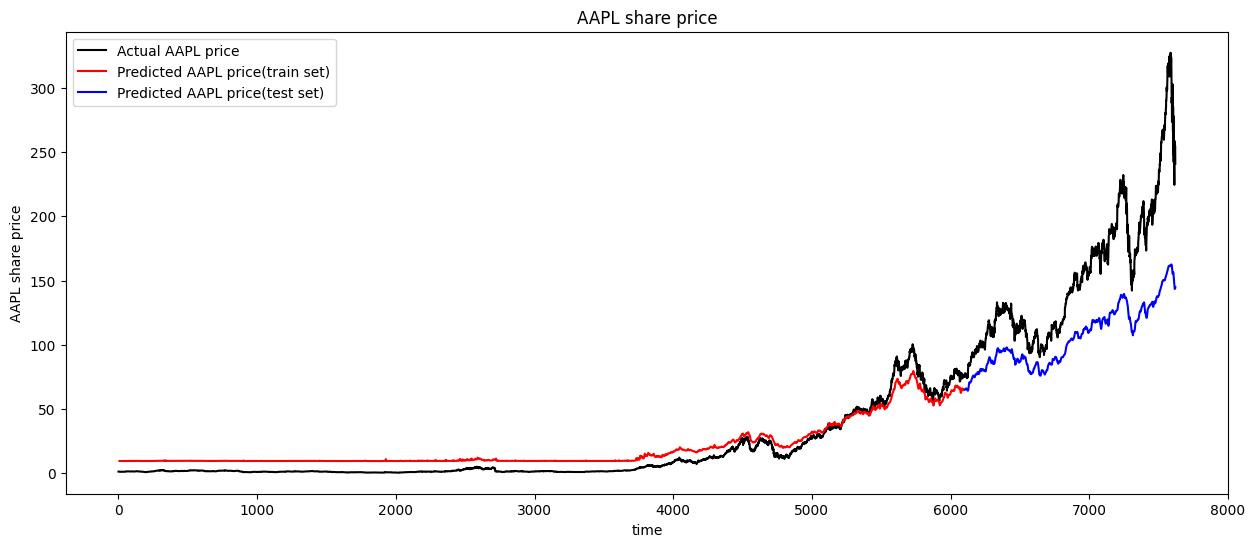

In [29]:
# Set the number of previous time steps to consider for plotting
look_back = past

# Initialize an array for plotting the train predictions
trainPredictPlot = np.empty_like(df["Close"])
trainPredictPlot[:] = np.nan
# Assign the predicted values to the appropriate location for train predictions
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

# Initialize an array for plotting the test predictions
testPredictPlot = np.empty_like(df["Close"])
testPredictPlot[:] = np.nan
# Calculate the starting index for the test predictions
test_start = len(df) - len(test_predict)
# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:] = test_predict.flatten()

# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = np.array(df["Close"])

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual {ticker} price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted {ticker} price(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted {ticker} price(test set)")

plt.title(f"{ticker} share price")
plt.xlabel("time")
plt.ylabel(f"{ticker} share price")
plt.legend()
plt.show()